In [2]:
import torch
import torchvision
import torch.nn as nn
torch.set_printoptions(profile="full") # or 'default'

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import umap
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import numpy as np
np.set_printoptions(suppress=True, linewidth=np.nan, precision=2, threshold=sys.maxsize)

In [3]:
USE_GPU = True
device = torch.device("cuda" if USE_GPU else "cpu")
trainset = torchvision.datasets.MNIST('./data', train=True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.MNIST('./data', train=False, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=6)
        

def vis_fc(act_list, layer_idx):
    fc_act = act_list[layer_idx][0].data.cpu().numpy()
    assert(len(fc_act)%20 == 0)
    plt.imshow(fc_act.reshape(10,len(fc_act)//10), cmap='gray')
    plt.suptitle('fc layer result, shape (1,500) ', fontsize=20)
    plt.savefig("fc.png")
    plt.show()
    

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28*1, 4096, bias=False)
        self.fc2 = nn.Linear(4096, 4096, bias=False)
        self.fc3 = nn.Linear(4096, 10, bias=False)

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        return nn.functional.log_softmax(x, dim=1)

model = Net()
model.load_state_dict(torch.load("./model/mlp_model"))
model = model.to(device)
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=4096, bias=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=False)
  (fc3): Linear(in_features=4096, out_features=10, bias=False)
)

In [4]:
%time test(model, device, test_loader)


Test set: Average loss: 0.0972, Accuracy: 9703/10000 (97%)

CPU times: user 264 ms, sys: 511 ms, total: 775 ms
Wall time: 1.27 s


Prepare Data for MNIST dataset
---

In [6]:
mnist_train_data = []
mnist_train_label = []
mnist_test_data = []
mnist_test_label = []
    
for image, label in trainset:    
    img = np.array(image.view(-1))
    mnist_train_data.append(img)
    mnist_train_label.append(label)
    
for image, label in testset:    
    img = np.array(image.view(-1))
    mnist_test_data.append(img)
    mnist_test_label.append(label)
    
mnist_train_data = np.vstack(mnist_train_data)
mnist_train_label = np.vstack(mnist_train_label).reshape(-1)
mnist_test_data = np.vstack(mnist_test_data)
mnist_test_label = np.vstack(mnist_test_label).reshape(-1)

print("train", mnist_train_data.shape, mnist_train_label.shape)
print("test", mnist_test_data.shape, mnist_test_label.shape)

train (60000, 784) (60000,)
test (10000, 784) (10000,)


PCA Unsupervised Learning
---

In [4]:
# Initialize the Scaler class object
pca = PCA(n_components=2)
# Perform PCA
data_reduced = pca.fit_transform(mnist_train_data)
print(data_reduced.shape)

(60000, 2)


In [5]:
sum(pca.explained_variance_ratio_[:100])

0.16800673305988312

In [6]:
pca.inverse_transform(data_reduced).shape

(60000, 784)

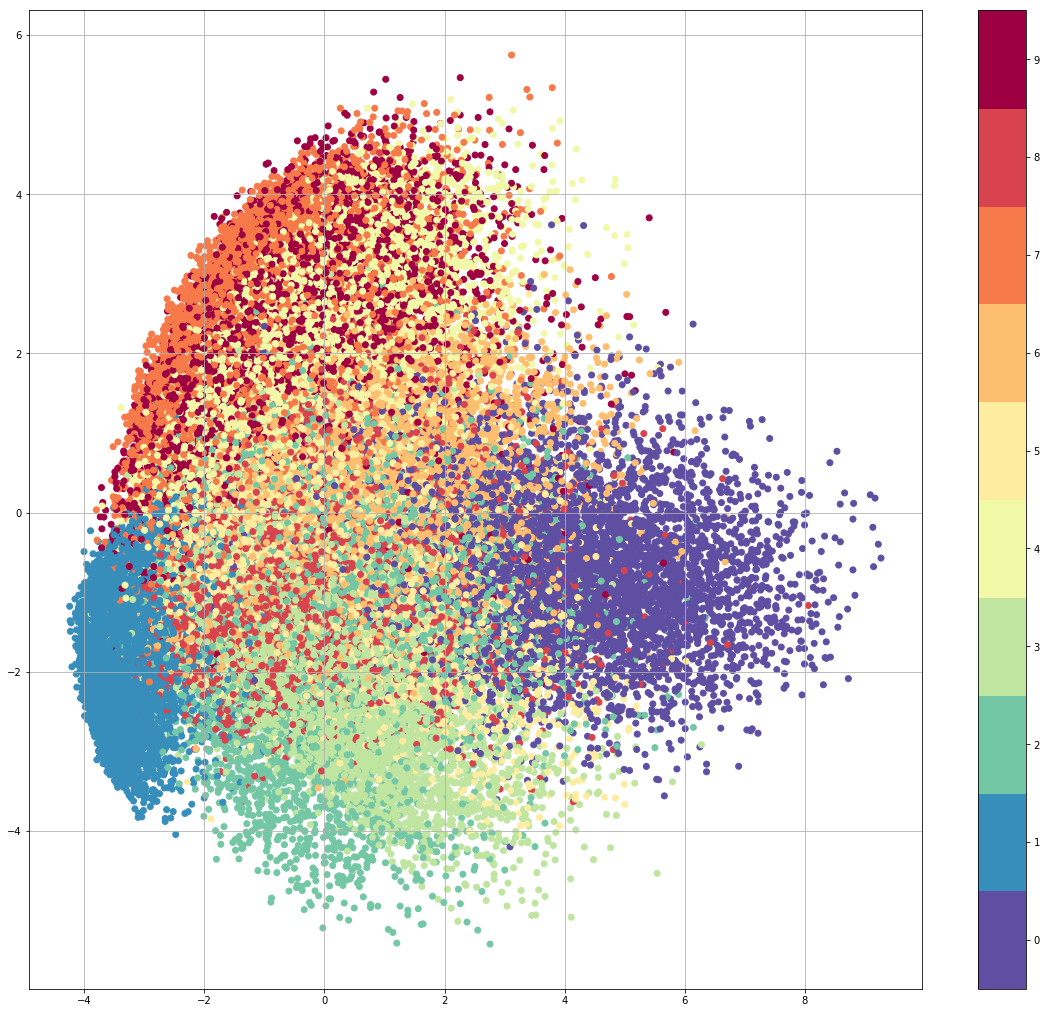

In [10]:
upper = -1
lower = 0
plt.figure(figsize = (20,18))
plt.scatter(data_reduced[lower:upper,0], data_reduced[lower:upper,1], c=mnist_train_label[lower:upper] , cmap='Spectral_r')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.grid()
plt.show()

UMAP Unsupervised Learning
---

In [11]:
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(mnist_train_data)

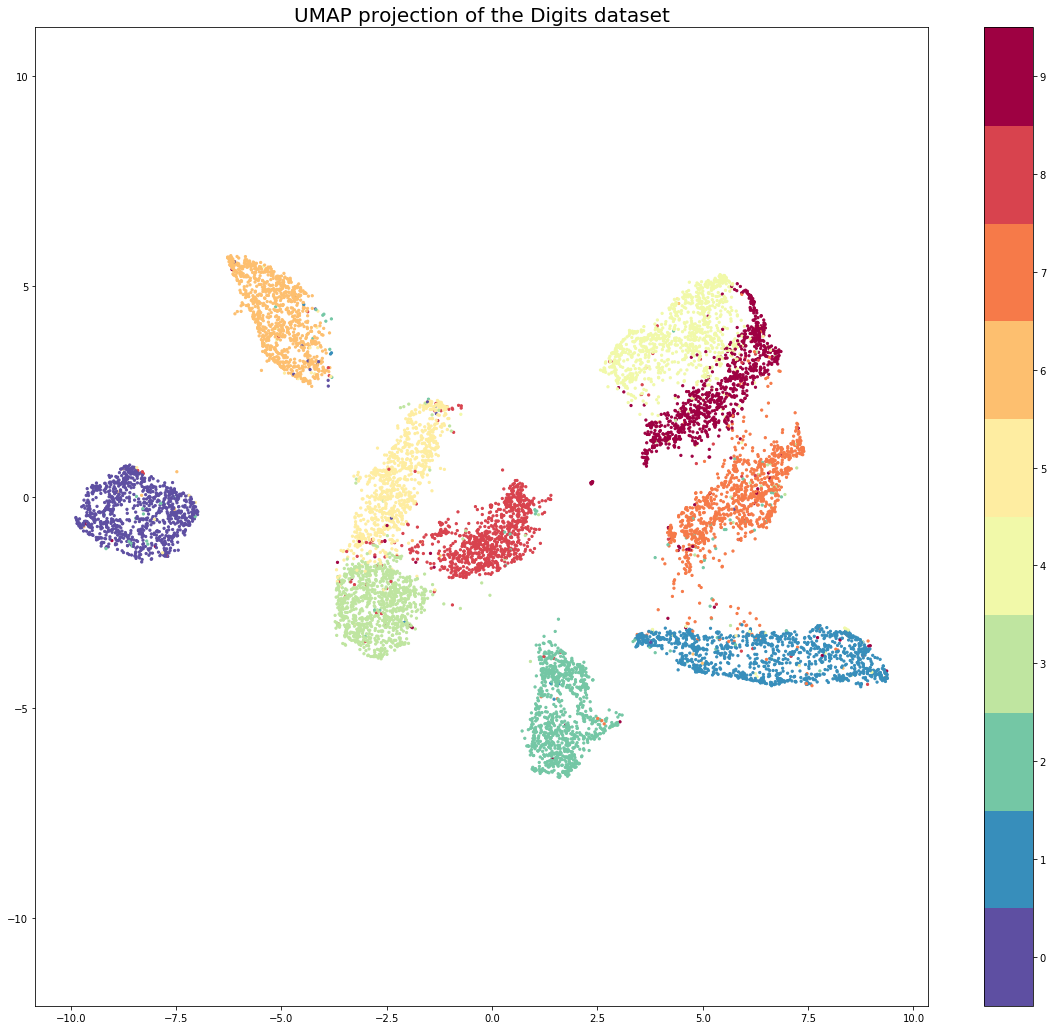

In [131]:
plt.figure(figsize = (20,18))
plt.scatter(embedding[:,0], embedding[:,1], c=mnist_train_label, cmap='Spectral_r', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

PCA Testing Acceleration
---

In [22]:
logisticRegr = LogisticRegression(solver = 'lbfgs', multi_class='auto')
%time logisticRegr.fit(mnist_train_data, mnist_train_label)

CPU times: user 1min 5s, sys: 574 ms, total: 1min 6s
Wall time: 8.56 s


/home/jjiangan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
%time logisticRegr.score(mnist_test_data, mnist_test_label)

CPU times: user 90.2 ms, sys: 28.2 ms, total: 118 ms
Wall time: 60.2 ms


0.9256

In [31]:
# Initialize the Scaler class object
pca = PCA(n_components=0.9)
# Perform PCA
data_reduced = pca.fit_transform(mnist_test_data)
print(data_reduced.shape)

(10000, 84)


In [39]:
%time logisticRegr.score(pca.inverse_transform(data_reduced), mnist_test_label)

CPU times: user 480 ms, sys: 27.9 ms, total: 508 ms
Wall time: 68.2 ms


0.9198

PCA Training/Testing Co-acceleration
---

In [48]:
# perform CPA on training data
pca = PCA(n_components=0.9)
mnist_train_data_reduced = pca.fit_transfoArm(mnist_train_data)
mnist_test_data_reduced = pca.transform(mnist_test_data)
print(mnist_train_data_reduced.shape, mnist_test_data_reduced.shape)

(60000, 87) (10000, 87)


In [41]:
# Train a logistic Regression Classifier on reduced training data
logisticRegr = LogisticRegression(solver = 'lbfgs', multi_class='auto')
%time logisticRegr.fit(mnist_train_data_reduced, mnist_train_label)

CPU times: user 16.9 s, sys: 325 ms, total: 17.2 s
Wall time: 2.21 s


/home/jjiangan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [54]:
# Perform prediction on reduced testing data
%time mnist_test_data_reduced = pca.transform(mnist_test_data)
%time logisticRegr.score(mnist_test_data_reduced, mnist_test_label)

CPU times: user 46.9 ms, sys: 77 µs, total: 47 ms
Wall time: 18.3 ms
CPU times: user 29.6 ms, sys: 201 µs, total: 29.8 ms
Wall time: 3.69 ms


0.9193

UMAP Training/Testing Co-acceleration
---

In [8]:
#perform UMAP on training data
reducer = umap.UMAP(n_components=30)
mnist_train_data_reduced_umap = reducer.fit_transform(mnist_train_data)

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [19]:
# Train a logistic Regression Classifier on reduced training data
logisticRegr = LogisticRegression(solver = 'lbfgs', multi_class='auto')
%time logisticRegr.fit(embedding, mnist_train_label)
print("Training Done")

CPU times: user 18.8 s, sys: 206 ms, total: 19 s
Wall time: 2.41 s
Training Done


/home/jjiangan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [23]:
# Perform prediction on reduced testing data
%time mnist_test_data_reduced_umap = reducer.transform(mnist_test_data)
%time score = logisticRegr.score(mnist_test_data_reduced_umap, mnist_test_label)
print("Testing Done, Score is ", Score)

CPU times: user 38.1 s, sys: 4.34 s, total: 42.4 s
Wall time: 28.1 s
CPU times: user 17.2 ms, sys: 1.14 ms, total: 18.3 ms
Wall time: 3.73 ms


NameError: name 'Score' is not defined